In [1]:
import pandas as pd
import math

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Lasso

import re
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

from gensim.models import Word2Vec

from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import Tensor

from ast import literal_eval
from collections import OrderedDict

from nn_helper import init_random_seed, train_eval_loop, predict_with_model

from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder, MultiLabelBinarizer

import youtokentome as yttm

import fasttext
import fasttext.util

plt.rcParams["figure.figsize"] = [6, 4]
tqdm.pandas()

SEED = 42

init_random_seed(SEED)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
device

device(type='cuda')

# Загрузка данных

In [3]:
df_train = pd.read_csv('data/vacancies_train.csv')
df_train

,name,experience,schedule,employment,description,key_skills,salary
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0
...,...,...,...,...,...,...,...
16624,Полицейский специального полка полиции,Нет опыта,Полный день,Полная занятость,Обязанности: обеспечение общественного поряд...,"['Грамотная речь', 'Обучение и развитие', 'Упр...",67500.0
16625,Врач стоматолог-ортопед (г. Новосибирск),Нет опыта,Полный день,Полная занятость,Обязанности: Оказывает квалифицированную меди...,['Медицинская документация'],50000.0
16626,Фармацевт,От 1 года до 3 лет,Полный день,Полная занятость,Условия: официальное оформление по ТК РФ; гра...,"['Пользователь ПК', 'Работа в команде', 'Грамо...",50000.0
16627,Геодезист (автодороги),От 1 года до 3 лет,Вахтовый метод,Полная занятость,Обязанности: своевременное и качественное вып...,[],75000.0


In [4]:
df_test = pd.read_csv('data/vacancies_test.csv', index_col=0)
df_test

,name,experience,schedule,employment,description,key_skills
id,,,,,,
0,Главный бухгалтер,Более 6 лет,Полный день,Полная занятость,Обязанности:Осуществление организации бухгалте...,"['1С: Предприятие 8', '1C: Предприятие', 'Рабо..."
1,Ассистент врача-стоматолога,От 1 года до 3 лет,Сменный график,Полная занятость,"Обязанности: Ассистировать врачу стоматологу,...","['Пользователь ПК', 'Работа в команде', 'Умени..."
2,Менеджер по продажам,От 1 года до 3 лет,Полный день,Полная занятость,Если ты: хочешь построить карьеру в банковс...,[]
3,Менеджер,От 1 года до 3 лет,Полный день,Полная занятость,Динамично развивающаяся на протяжении 17 лет...,"['Оценка потребностей клиентов', 'оформление д..."
4,Администратор хостела,Нет опыта,Сменный график,Полная занятость,ВОЗМОЖНА РАБОТА С ПРОЖИВАНИЕМ Обязанности: Пр...,[]
...,...,...,...,...,...,...
5538,Специалист по дистанционному контролю качества...,От 1 года до 3 лет,Удаленная работа,Полная занятость,Обязанности: проводить визуальный контроль а...,"['Удаленная работа', 'Грамотная речь', 'Пользо..."
5539,Продавец-консультант,Нет опыта,Полный день,Полная занятость,Компания ONE SMOKE приглашает к сотрудничеству...,"['Пользователь ПК', 'Розничная торговля', 'Раб..."
5540,Фельдшер скорой медицинской помощи,От 3 до 6 лет,Сменный график,Полная занятость,Обязанности: Осуществляет оказание скорой мед...,[]


# Простейший EDA

<Axes: xlabel='salary', ylabel='Count'>

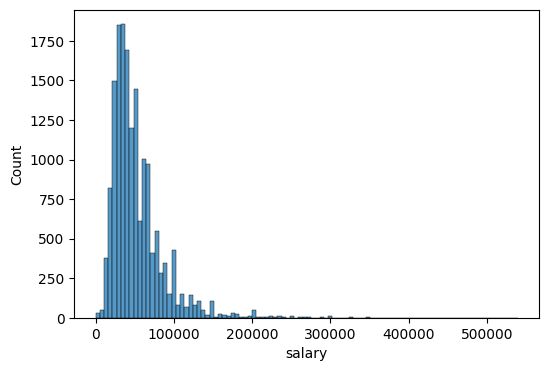

In [8]:
sns.histplot(df_train.salary, bins=100)

In [9]:

q_low = df_train["salary"].quantile(0.1)
q_hi  = df_train["salary"].quantile(0.9995)

df_train = df_train[(df_train["salary"] < 350_000.0) & (df_train["salary"] > 16_000.0)].copy()
df_train.reset_index(drop=True, inplace=True)


<Axes: >

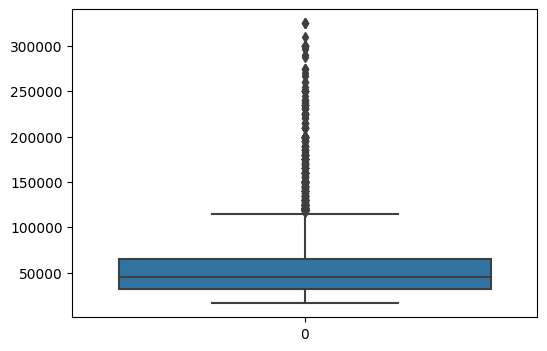

In [10]:
sns.boxplot(df_train.salary)

<Axes: xlabel='salary', ylabel='Count'>

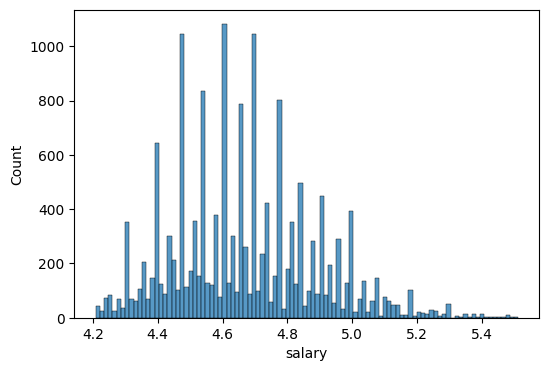

In [11]:
sns.histplot(np.log10(df_train.salary + 1), bins=100)

In [12]:
df_train.name.value_counts()

Менеджер по продажам                                                  207
Продавец-консультант                                                  179
Кладовщик                                                             111
Менеджер по работе с клиентами                                        110
Бухгалтер                                                             108
                                                                     ... 
Продавец-консультант цифровой техники(г.Краснодар, Новый Горизонт)      1
Конструктор производства мягкой мебели                                  1
Упаковщица/Упаковщик                                                    1
Помощник официанта,ранер                                                1
Специалист-эксперт отдела правового обеспечения                         1
Name: name, Length: 9736, dtype: int64

In [13]:
df_test.name.value_counts()

Менеджер по продажам                                                70
Продавец-консультант                                                65
Кладовщик                                                           51
Менеджер по работе с клиентами                                      36
Медицинская сестра                                                  34
                                                                    ..
Disposal (диспозл)-менеджер по привлечению объектов недвижимости     1
Товаровед-Продавец                                                   1
Слесарь-ремонтник (5 разряд)                                         1
Повар (Камчатский край, Артель)                                      1
Торговый представитель (Колпино, Тосно, Кировск)                     1
Name: name, Length: 3716, dtype: int64

По графику ниже, видим, что вакансий для опытных соискателей сравнительно немного. **Попробуйте визуализировать совместное распределение опыта работы и предлагаемой зп**

<Axes: xlabel='experience', ylabel='Count'>

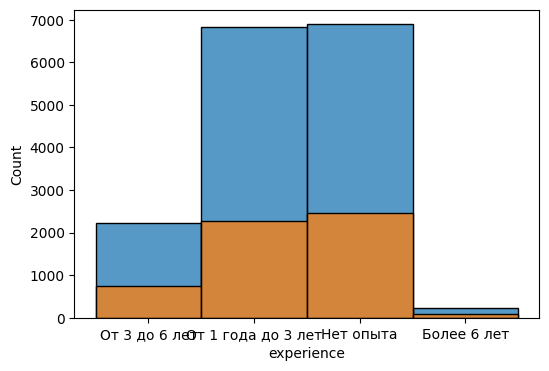

In [14]:
sns.histplot(df_train.experience)
sns.histplot(df_test.experience)

<Axes: xlabel='schedule', ylabel='Count'>

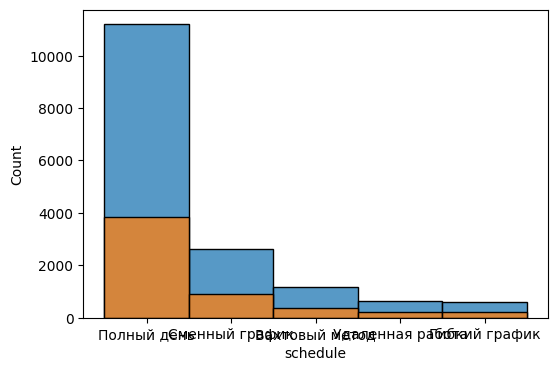

In [15]:
sns.histplot(df_train.schedule)
sns.histplot(df_test.schedule)

<Axes: xlabel='employment', ylabel='Count'>

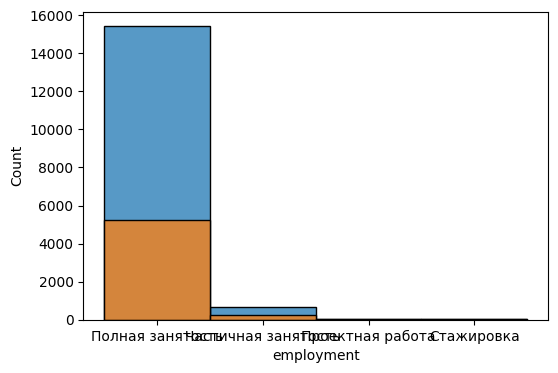

In [16]:
sns.histplot(df_train.employment)
sns.histplot(df_test.employment)

# Preprocessing

In [5]:
stop_words = set(stopwords.words('russian'))
morph = MorphAnalyzer()

# функция для очистки описаний
def clean_text(text):
    text = re.sub(r'http\S+', '', text) # избавляемся от ссылок
    text = re.sub('[^а-яёА-ЯЁa-zA-Z]', ' ', text) # оставляем только кириллицу
    text = word_tokenize(text.lower()) # приводим к нижнему регистру и токенизируем по словам
    # приводим токены к нормальной форме, удаляем стоп-слова и короткие токены
    text = [morph.normal_forms(token)[0] for token in text if len(token) > 1 and token not in stop_words]
    text = " ".join(text) # возвращаем строку
    return text

In [6]:
def clean_key_skills(skill_list):
    new_list = []
    list_of_skills = literal_eval(skill_list)
    for text in list_of_skills:
        text = re.sub(r'http\S+', '', text) # избавляемся от ссылок
        text = re.sub('[^а-яёА-ЯЁa-zA-Z]', ' ', text) # оставляем только кириллицу
        text = word_tokenize(text.lower()) # приводим к нижнему регистру и токенизируем по словам
        # приводим токены к нормальной форме, удаляем стоп-слова и короткие токены
        text = [morph.normal_forms(token)[0] for token in text if len(token) > 1 and token not in stop_words]
        text = " ".join(text) # возвращаем строку
        if text:
            new_list.append(text)
    return str(new_list)

df_train['key_skills'] = df_train.key_skills.progress_apply(clean_key_skills)
df_test['key_skills'] = df_test.key_skills.progress_apply(clean_key_skills)
df_train['key_skills']

100%|██████████| 5543/5543 [00:06<00:00, 869.24it/s]


0                                                       []
1        ['знание пк', 'работа', 'работа команда', 'скл...
2                                                       []
3                                                       []
4        ['пользователь пк', 'грамотный речь', 'работа ...
                               ...                        
16624    ['грамотный речь', 'обучение развитие', 'управ...
16625                         ['медицинский документация']
16626    ['пользователь пк', 'работа команда', 'грамотн...
16627                                                   []
16628    ['грамотный речь', 'пользователь пк', 'умение ...
Name: key_skills, Length: 16629, dtype: object

In [7]:
df_train['name_cleaned'] = df_train.name.progress_apply(clean_text)
df_train['description_cleaned'] = df_train.description.progress_apply(clean_text)
df_train

100%|██████████| 16629/16629 [03:47<00:00, 73.10it/s]


,name,experience,schedule,employment,description,key_skills,salary,name_cleaned,description_cleaned
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0,водитель экспедитор,водитель экспедитор категория газель тент газе...
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа', 'работа команда', 'скл...",50000.0,кладовщик комплектовщик оператор,обязанность списывание материал производство п...
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0,продавец магазин магнит кировский уса,крупный федеральный сеть магазин магнит требов...
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0,администратор магазин тц spar,крупный федеральный сеть магазин мужской женск...
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['пользователь пк', 'грамотный речь', 'работа ...",37000.0,мойщик посуда кулинария,обязанность уборка производственный площадь ку...
...,...,...,...,...,...,...,...,...,...
16624,Полицейский специального полка полиции,Нет опыта,Полный день,Полная занятость,Обязанности: обеспечение общественного поряд...,"['грамотный речь', 'обучение развитие', 'управ...",67500.0,полицейский специальный полка полиция,обязанность обеспечение общественный порядок о...
16625,Врач стоматолог-ортопед (г. Новосибирск),Нет опыта,Полный день,Полная занятость,Обязанности: Оказывает квалифицированную меди...,['медицинский документация'],50000.0,врач стоматолог ортопед новосибирск,обязанность оказывать квалифицировать медицинс...
16626,Фармацевт,От 1 года до 3 лет,Полный день,Полная занятость,Условия: официальное оформление по ТК РФ; гра...,"['пользователь пк', 'работа команда', 'грамотн...",50000.0,фармацевт,условие официальный оформление тк рф график ра...
16627,Геодезист (автодороги),От 1 года до 3 лет,Вахтовый метод,Полная занятость,Обязанности: своевременное и качественное вып...,[],75000.0,геодезист автодорога,обязанность своевременный качественный выполне...


In [8]:
df_test['name_cleaned'] = df_test.name.progress_apply(clean_text)
df_test['description_cleaned'] = df_test.description.progress_apply(clean_text)
df_test

100%|██████████| 5543/5543 [01:18<00:00, 71.04it/s]


,name,experience,schedule,employment,description,key_skills,name_cleaned,description_cleaned
id,,,,,,,,
0,Главный бухгалтер,Более 6 лет,Полный день,Полная занятость,Обязанности:Осуществление организации бухгалте...,"['предприятие', 'предприятие', 'работа докумен...",главный бухгалтер,обязанность осуществление организация бухгалте...
1,Ассистент врача-стоматолога,От 1 года до 3 лет,Сменный график,Полная занятость,"Обязанности: Ассистировать врачу стоматологу,...","['пользователь пк', 'работа команда', 'умение ...",ассистент врач стоматолог,обязанность ассистировать врач стоматолог подг...
2,Менеджер по продажам,От 1 года до 3 лет,Полный день,Полная занятость,Если ты: хочешь построить карьеру в банковс...,[],менеджер продажа,хотеть построить карьера банковский сектор ори...
3,Менеджер,От 1 года до 3 лет,Полный день,Полная занятость,Динамично развивающаяся на протяжении 17 лет...,"['оценка потребность клиент', 'оформление доку...",менеджер,динамично развивающийся протяжение год компани...
4,Администратор хостела,Нет опыта,Сменный график,Полная занятость,ВОЗМОЖНА РАБОТА С ПРОЖИВАНИЕМ Обязанности: Пр...,[],администратор хостел,возможный работа проживание обязанность приём ...
...,...,...,...,...,...,...,...,...
5538,Специалист по дистанционному контролю качества...,От 1 года до 3 лет,Удаленная работа,Полная занятость,Обязанности: проводить визуальный контроль а...,"['удалённый работа', 'грамотный речь', 'пользо...",специалист дистанционный контроль качество янд...,обязанность проводить визуальный контроль авто...
5539,Продавец-консультант,Нет опыта,Полный день,Полная занятость,Компания ONE SMOKE приглашает к сотрудничеству...,"['пользователь пк', 'розничный торговля', 'раб...",продавец консультант,компания one smoke приглашать сотрудничество м...
5540,Фельдшер скорой медицинской помощи,От 3 до 6 лет,Сменный график,Полная занятость,Обязанности: Осуществляет оказание скорой мед...,[],фельдшер скорый медицинский помощь,обязанность осуществлять оказание скорый медиц...


<Axes: xlabel='description_cleaned', ylabel='Count'>

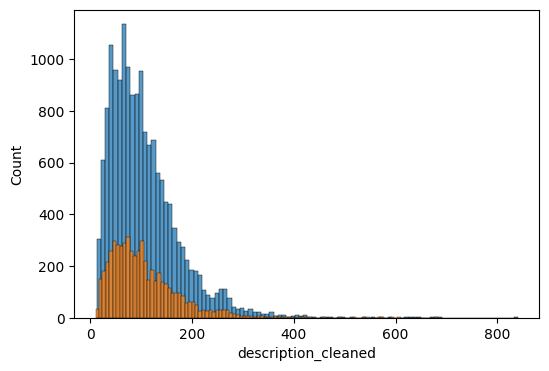

In [23]:
sns.histplot(df_train.description_cleaned.str.split().apply(len), bins=100)
sns.histplot(df_test.description_cleaned.str.split().apply(len), bins=100)

<Axes: xlabel='name_cleaned', ylabel='Count'>

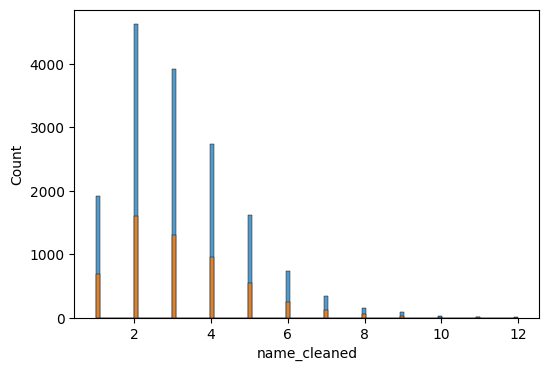

In [22]:
sns.histplot(df_train.name_cleaned.str.split().apply(len), bins=100)
sns.histplot(df_test.name_cleaned.str.split().apply(len), bins=100)

In [24]:
# df_train[['experience', 'schedule', 'name_cleaned','salary', 'description_cleaned', 'key_skills', 'employment', 'name', 'description']].to_csv('data/train_clean.csv', index=False)
# df_test[['experience', 'schedule', 'name_cleaned','description_cleaned', 'key_skills', 'employment', 'name', 'description']].to_csv('data/test_clean.csv')

# df_train.to_csv('data/train_clean.csv', index=False)
# df_test.to_csv('data/test_clean.csv')

# df_train = pd.read_csv('data/train_clean.csv')
# df_test = pd.read_csv('data/test_clean.csv', index_col=0)

# Word2Vec

Обучаемся на словах только из трейна. **Попробуйте взять окно пошире и//или изменить размер эмбеддинга.**

In [ ]:
w2v_model = Word2Vec(sentences=list(df_train.name_cleaned.str.split()),
                     vector_size=100, window=5, workers=4, min_count=0)

In [ ]:
%%script echo skipping

doc_vectors_train = []
row = 0

for doc in tqdm(df_train.cleaned.str.split()):
    res = np.zeros(100)
    cnt = 0
    for word in doc:
        if w2v_vectors.__contains__(word):
            res += w2v_model.wv[word]
            cnt += 1
    if cnt != 0:
        res /= cnt
    doc_vectors_train.append(res)

doc_vectors_train = np.array(doc_vectors_train)

In [ ]:
%%script echo skipping

doc_vectors_test = []
row = 0

for doc in tqdm(df_test.cleaned.str.split()):
    res = np.zeros(100)
    cnt = 0
    for word in doc:
        if w2v_vectors.__contains__(word):
            res += w2v_model.wv[word]
            cnt += 1
    if cnt != 0:
        res /= cnt
    doc_vectors_test.append(res)

doc_vectors_test = np.array(doc_vectors_test)

# Fit & Predict

In [9]:
def decimal_to_binary_tensor(value, width=0):
    string = format(value, '0{}b'.format(width))
    binary = [0 if c == '0' else 1 for c in string]
    return torch.tensor(binary, dtype=torch.uint8)

def ensure_length(txt, out_len, pad_value):
    if len(txt) < out_len:
        txt = list(txt) + [pad_value] * (out_len - len(txt))
    else:
        txt = txt[:out_len]
    return txt

In [ ]:
BPE_MODEL_FILENAME = 'data/salary.yttm'
TRAIN_TEXTS_FILENAME = 'data/salary.txt'
with open(TRAIN_TEXTS_FILENAME, 'w') as outf:
    outf.write('\n'.join(df_train.cleaned.tolist()))
yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=5000, model=BPE_MODEL_FILENAME)
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)

In [10]:
df_train = df_train.groupby(['name_cleaned', 'experience','schedule','employment', 'description_cleaned'], as_index=False, sort=False).agg(
    { column: 'mean' if column == 'salary' else 'first' for column in df_train.columns } ).reset_index(drop=True).copy()

In [11]:
experience_encoder = LabelEncoder()
schedule_encoder = LabelEncoder()
employment_encoder = LabelEncoder()
df_train['experience_category'] = experience_encoder.fit_transform(df_train.experience)
df_train['schedule_category'] = schedule_encoder.fit_transform(df_train.schedule)
df_train['employment_category'] = employment_encoder.fit_transform(df_train.employment)
df_test['experience_category'] = experience_encoder.transform(df_test.experience)
df_test['schedule_category'] = schedule_encoder.transform(df_test.schedule)
df_test['employment_category'] = employment_encoder.transform(df_test.employment)

EXPERIENCE_BITS_LEN = 3
SCHEDULE_BITS_LEN = 3
EMPLOYMENT_BITS_LEN = 3

In [12]:
key_skills_encoder = MultiLabelBinarizer()
key_skills = df_train.key_skills.apply(literal_eval)
key_skills_category = key_skills_encoder.fit_transform(key_skills)
df_train['key_skills_category'] = key_skills_category.tolist()
df_test['key_skills_category'] = key_skills_encoder.transform(df_test.key_skills.apply(literal_eval)).tolist()

/home/evigurskiy/.venvs/sharedenv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['amadeus', 'app', 'aws', 'beta тестирование', 'borland', 'brainysoft', 'capture one pro', 'cat программа', 'cinema production', 'cms modx', 'cucumber', 'cypress', 'data mining statistica', 'data science', 'design patterns', 'destiny', 'dipifr', 'directum', 'driving licence', 'epc', 'fashion', 'film production', 'final cut', 'flask', 'flutter', 'freebsd', 'gabriel', 'game programming', 'gmp good manufacturing practice', 'grid', 'growth hacking', 'growth marketing', 'hadoop', 'hardware', 'hr стратегия', 'influencer', 'it рекрутинг', 'java ee', 'jdbc', 'junit', 'machine learning', 'magicad', 'mathematical analysis', 'mathematical statistics', 'microservices', 'microsoft', 'ml', 'mqtt', 'ms office word excel', 'pixel perfect', 'pos терминал', 'rdp', 'react redux', 'restapi', 'rhel centos fedora', 'scc', 'scenekit', 'scikit learn', 'selenuim', 'sirena', 'sketch

In [13]:
train_key_skills_df = pd.DataFrame(key_skills_category,columns=key_skills_encoder.classes_)
train_key_skills_df['sum'] = train_key_skills_df.sum(axis=1)
train_key_skills_df['salary'] = df_train.salary
key_skills_sorted = train_key_skills_df.sum().sort_values()
key_skills_sorted = key_skills_sorted[key_skills_sorted > 10].index
corr = train_key_skills_df[key_skills_sorted].corr()

In [14]:
most_correlated_features = corr.salary.abs().sort_values(ascending=False)[0:50].drop(['salary']).index
df_train['key_skills_category'] = train_key_skills_df[most_correlated_features].to_numpy().tolist()

In [15]:
train_key_skills_category = key_skills_encoder.transform(df_test.key_skills.apply(literal_eval))
test_key_skills_df = pd.DataFrame(train_key_skills_category,columns=key_skills_encoder.classes_)
test_key_skills_df['sum'] = test_key_skills_df.sum(axis=1)
df_test['key_skills_category'] = test_key_skills_df[most_correlated_features].to_numpy().tolist()

/home/evigurskiy/.venvs/sharedenv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['amadeus', 'app', 'aws', 'beta тестирование', 'borland', 'brainysoft', 'capture one pro', 'cat программа', 'cinema production', 'cms modx', 'cucumber', 'cypress', 'data mining statistica', 'data science', 'design patterns', 'destiny', 'dipifr', 'directum', 'driving licence', 'epc', 'fashion', 'film production', 'final cut', 'flask', 'flutter', 'freebsd', 'gabriel', 'game programming', 'gmp good manufacturing practice', 'grid', 'growth hacking', 'growth marketing', 'hadoop', 'hardware', 'hr стратегия', 'influencer', 'it рекрутинг', 'java ee', 'jdbc', 'junit', 'machine learning', 'magicad', 'mathematical analysis', 'mathematical statistics', 'microservices', 'microsoft', 'ml', 'mqtt', 'ms office word excel', 'pixel perfect', 'pos терминал', 'rdp', 'react redux', 'restapi', 'rhel centos fedora', 'scc', 'scenekit', 'scikit learn', 'selenuim', 'sirena', 'sketch

In [16]:
salary_scaler = StandardScaler()
df_train['salary_scaled'] = salary_scaler.fit_transform(np.array(df_train.salary).reshape(-1,1))

In [17]:
name_vect = TfidfVectorizer()
description_vect = TfidfVectorizer()
name_vect.fit(df_train.name_cleaned)
description_vect.fit(df_train.description_cleaned)
transformed = description_vect.transform([df_train.description_cleaned[0]])
inv_map = {v: k for k, v in description_vect.vocabulary_.items()}


In [ ]:
with open('data/salary.txt','w') as tfile:
	tfile.write('\n'.join((df_train.name_cleaned + " " + df_train.description_cleaned).tolist()))

In [ ]:
FASTTEXT_EMB_LEN = 100
ft = fasttext.train_unsupervised(input = 'data/salary.txt')
ft.save_model('data/salary100.bin')

In [18]:
FASTTEXT_EMB_LEN = 100
fasttext.util.download_model('ru', if_exists='ignore')
# ft = fasttext.load_model('cc.ru.300.bin')
ft = fasttext.load_model('data/salary100.bin')
# fasttext.util.reduce_model(ft, 100)

In [19]:
df_test['id_column'] = df_test.index
full_match = pd.merge(df_train, df_test, how ='inner', on =['name_cleaned', 'experience','schedule','employment', 'description_cleaned'])
full_match_mean_salary = full_match.groupby(by=['id_column']).salary.mean()
print(f"Found full match dups={len(full_match_mean_salary)}")

partial_match = pd.merge(df_train, df_test, how ='inner', on =['name_cleaned', 'experience','schedule','employment'])
partial_match_mean_salary = partial_match.groupby(by=['id_column']).salary.mean()
print(f"Found partial dups={len(partial_match_mean_salary)}")

name_match = pd.merge(df_train, df_test, how ='inner', on =['name_cleaned', 'experience','schedule'])
name_match_mean_salary = name_match.groupby(by=['id_column']).salary.mean()
print(f"Found name dups={len(name_match_mean_salary)}")


Found full match dups=279
Found partial dups=2247
Found name dups=2315


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
# DeepPavlov/rubert-base-cased
# cointegrated/rubert-tiny2
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
bert_model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

class BertSalaryModel(nn.Module):

    def __init__(self, backbone_model):
        super().__init__()
        self.backbone_model = backbone_model
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x: Tensor) -> Tensor:
        ids = x['input_ids'].squeeze(1)
        mask = x['attention_mask'].squeeze(1) 
        x = self.backbone_model(input_ids=ids, attention_mask=mask).last_hidden_state[:, 0, :]
        x = self.relu(self.pre_classifier(x))
        x = self.dropout(x)
        x = self.classifier(x)
        return x

bert_salary_model = BertSalaryModel(bert_model)
bert_salary_model_description = BertSalaryModel(bert_model)

In [ ]:
def embed_bert_cls(text):
    t = tokenizer(text, padding='max_length', truncation=True, return_tensors='pt', max_length=15)
    with torch.no_grad():
        model_output = bert_model(**{k: v.to(bert_model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    return embeddings[0].cpu().numpy()

In [ ]:
class BertDataset(Dataset):
    
    def __init__(self, df: pd.DataFrame, is_train=True) -> None:
        super().__init__()
        self.is_train = is_train
        self.data = df
        
    def clean_text(self, text):
        text = re.sub(r'http\S+', '', text) # избавляемся от ссылок
        text = re.sub('[^а-яёА-ЯЁa-zA-Z0-8]', ' ', text) # оставляем только кириллицу
        return text.lower() # приводим к нижнему регистру и токенизируем по словам
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        name = self.data.name[index]
        description = self.data.description[index]
        name = self.clean_text(name)
        # description = self.clean_text(description)
        text_input = name
        tensor_input = tokenizer(text_input, padding='max_length', truncation=True, return_tensors='pt', max_length=15)
        
        if self.is_train:        
            return (
                {k: v.to(bert_model.device) for k, v in tensor_input.items()},
                torch.tensor(self.data.salary_scaled[index], dtype=torch.float32).unsqueeze(0)
                )
        else:
            return ({k: v.to(bert_model.device) for k, v in tensor_input.items()},torch.tensor([0.0]))
        
train, val = train_test_split(df_train, test_size=0.2, random_state=SEED)
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

bert_full_dataset = BertDataset(df_train)
bert_train_dataset = BertDataset(train)
bert_val_dataset = BertDataset(val)
bert_test_dataset = BertDataset(df_test, is_train=False)

bert_train_dataset[2]

In [ ]:
sns.heatmap(np.array(df_train[df_train.name_cleaned.str.contains('стажёр')].name_cleaned.apply(embed_bert_cls).tolist()))

In [ ]:
sns.heatmap(np.array(df_train[df_train.name_cleaned.str.contains('программист')].name_cleaned.apply(embed_bert_cls).tolist()))

In [ ]:
BATCH_SIZE = 2

def scheduler(optim): return \
    torch.optim.lr_scheduler.ReduceLROnPlateau(
        optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(model=bert_salary_model,
                                            device=device,
                                            train_dataset=bert_train_dataset,
                                            val_dataset=bert_val_dataset,
                                            criterion=F.mse_loss,
                                            lr=1e-4,
                                            epoch_n=10,
                                            batch_size=BATCH_SIZE,
                                            l2_reg_alpha=0.1,
                                            lr_scheduler_ctor=scheduler,
                                            shuffle_train=False
                                            )

In [72]:
MAX_NAME_SEQ_LEN = 6
MAX_DESC_SEQ_LEN = 200
KEY_SKILLS_OHE_LEN = key_skills_category.shape[1]

class CustomDataset(Dataset):

    def __init__(self, df: pd.DataFrame, is_train=True):
        self.is_train = is_train
        self.data = df
        self.name = df.name
        self.description = df.description
        if is_train:
            self.target = df.salary_scaled
        self.experience_category = df.experience_category
        self.schedule_category = df.schedule_category
        self.employment_category = df.employment_category
        self.key_skills_category = df.key_skills_category
        self.name_tfidf_map = {v: k for k, v in name_vect.vocabulary_.items()}
        self.description_tfidf_map = {v: k for k, v in description_vect.vocabulary_.items()}
        
    def get_yttm_encoding(self, description):
        input_ids = tokenizer.encode(description, bos=True, eos=True)
        input_ids = ensure_length(input_ids, MAX_DESC_SEQ_LEN, 0)
        input_ids = torch.tensor(input_ids)
        src_key_input_mask = input_ids > 0
        return input_ids, src_key_input_mask
    
    def get_fasttext_encoding(self, description):
        input_ids = torch.zeros((MAX_DESC_SEQ_LEN,FASTTEXT_EMB_LEN), dtype=torch.float32)
        for i, word in enumerate(description.split()):
            if i >= MAX_DESC_SEQ_LEN:
                break
            input_ids[i] = torch.tensor(ft[word])
        return input_ids
    
    def get_bert_encoding(self, description, max_len):
        return embed_bert_cls(self.clean_text(description)), torch.zeros((max_len,), dtype=torch.bool)
    
    def get_fasttext_tfidf_encoding(self, description, tfidf, max_len, word_map):
        # return ft[description], torch.zeros((max_len,), dtype=torch.bool)
        input_ids = torch.zeros((max_len,FASTTEXT_EMB_LEN), dtype=torch.float32)
        input_mask = torch.zeros((max_len,), dtype=torch.bool)
        desc_tfidf = tfidf.transform([description])
        
        
        tfs_values = desc_tfidf[desc_tfidf.nonzero()].A
        tfs_indices = desc_tfidf.indices.reshape(1,-1)
        conc = np.concatenate((tfs_values, tfs_indices), axis=0)
        conc = conc[:,conc[0,:].argsort()[::-1]]
        sorted_values = conc[0]
        sorted_indexes = conc[1]
        words = ""
        for i, word_id in enumerate(sorted_indexes):
            word_id = int(word_id)
            if i >= max_len:
                break
            word = word_map[word_id]
            words += " " + word
            word_weight = sorted_values[i]
            word_vec = ft[word]
            input_ids[i] = torch.tensor(word_vec*word_weight)
            input_mask[i] = True
        return ft[words.strip()], torch.zeros((max_len,), dtype=torch.bool)

    def get_word2vec_encoding(self, description):
        input_ids = torch.zeros((MAX_DESC_SEQ_LEN,), dtype=torch.int32)
        for i, word in enumerate(description.split()):
            if i >= MAX_DESC_SEQ_LEN:
                break
            if w2v_model.__contains__(word):
                input_ids[i] = w2v_model.wv.key_to_index[word]
                
        src_key_input_mask = torch.zeros((MAX_DESC_SEQ_LEN,), dtype=torch.bool)
        src_key_input_mask[:i+1] = True
        return input_ids, src_key_input_mask


    def clean_text(self, text):
        text = re.sub(r'http\S+', '', text) # избавляемся от ссылок
        text = re.sub('[^а-яёА-ЯЁa-zA-Z0-8]', ' ', text) # оставляем только кириллицу
        return text.lower() # приводим к нижнему регистру и токенизируем по словам
    
    
    def __len__(self):
        return len(self.description)

    def __getitem__(self, index):
        name = self.name[index]
        description = self.description[index]
        name_input_ids, name_input_mask = self.get_fasttext_tfidf_encoding(name, name_vect, MAX_NAME_SEQ_LEN, self.name_tfidf_map)
        desc_input_ids, desc_input_mask = self.get_fasttext_tfidf_encoding(description, description_vect, MAX_DESC_SEQ_LEN, self.description_tfidf_map)
        # name_input_ids, name_input_mask = self.get_bert_encoding(name, MAX_NAME_SEQ_LEN)
        # desc_input_ids, desc_input_mask = self.get_bert_encoding(description, MAX_DESC_SEQ_LEN)
        experience = decimal_to_binary_tensor(self.experience_category[index], EXPERIENCE_BITS_LEN)
        schedule = decimal_to_binary_tensor(self.schedule_category[index], SCHEDULE_BITS_LEN)
        employment = decimal_to_binary_tensor(self.employment_category[index], EMPLOYMENT_BITS_LEN)
        
        # experience = torch.tensor(self.experience_category[index])
        # schedule = torch.tensor(self.schedule_category[index])
        # employment = torch.tensor(self.employment_category[index] )
        
        key_skills = torch.tensor(self.key_skills_category[index], dtype=torch.uint8)
        
        if self.is_train:        
            return (
                {
                    "name_input_ids" :  name_input_ids, 
                    "name_input_mask" :  name_input_mask, 
                    "desc_input_ids" :  desc_input_ids, 
                    "desc_input_mask" :  desc_input_mask, 
                    "experience" :  experience,   
                    "schedule" :  schedule,   
                    "employment" :  employment,   
                    "key_skills" :  key_skills,   
                },
                torch.tensor(self.target[index], dtype=torch.float32).unsqueeze(0)
                )
        else:
            return ({
                    "name_input_ids" :  name_input_ids, 
                    "name_input_mask" :  name_input_mask, 
                    "desc_input_ids" :  desc_input_ids, 
                    "desc_input_mask" :  desc_input_mask, 
                    "experience" :  experience,   
                    "schedule" :  schedule,   
                    "employment" :  employment,   
                    "key_skills" :  key_skills,   
                },torch.tensor([0.0]))

train, val = train_test_split(df_train, test_size=0.2, random_state=SEED)
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

full_dataset = CustomDataset(df_train)
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val)
test_dataset = CustomDataset(df_test, is_train=False)

full_dataset[2]

({'name_input_ids': array([-0.30611783,  1.161824  ,  0.3092959 ,  0.27569383,  0.6718018 ,
         -0.19970411,  0.4452368 , -0.17820194,  0.75672203, -0.15597071,
         -0.7540466 , -0.30784404, -0.12905546,  0.61110824,  0.09628776,
          0.16447449,  0.7176572 ,  0.06638356, -0.37733278, -0.4594517 ,
         -0.18960159,  0.7656545 , -0.29751533, -0.28195843,  0.92888314,
          0.17950422,  0.7562714 ,  0.5135378 , -0.11467884,  0.23664662,
         -0.43362948, -0.14219123,  0.00120605,  0.01342907, -0.17848343,
         -0.13191181, -0.13757071,  0.7888567 , -0.23718849,  0.717358  ,
          0.8691426 , -0.10300688, -0.22655666,  0.08935997,  0.22646107,
          0.08381691, -0.23569676,  0.11520504, -0.00815473,  0.21295173,
         -0.66632134, -0.67986083,  0.38339698,  0.14642654,  0.18054576,
          0.4464058 ,  0.41664508, -0.00541365,  0.2577479 , -0.64326704,
         -0.03957413, -0.26340446, -0.46915287,  0.5525689 , -0.65174127,
         -0.10859248

In [22]:
import tqdm

VEC_LEN = 258
def vectorize(dataset):
    X = np.zeros((len(dataset), VEC_LEN), dtype=np.float32)
    y = np.zeros((len(dataset),), dtype=np.float32)
    for el, inp in enumerate(tqdm.tqdm(dataset, total=len(dataset))):
        src, trg = inp
        name_input_ids = src['name_input_ids']
        desc_input_ids = src['desc_input_ids']
        name_input_mask = src['name_input_mask']
        desc_input_mask = src['desc_input_mask']
        experience = src['experience'].numpy()
        schedule = src['schedule'].numpy()
        employment = src['employment'].numpy()
        key_skills = src['key_skills'].numpy()
        name_vec = name_input_ids
        desc_vec = desc_input_ids
        X[el] = np.concatenate((schedule, experience, employment, name_vec, desc_vec, key_skills))
        y[el] = trg.numpy()
        if el == len(dataset)-1:
            break
    return X, y

Xtrain, ytrain = vectorize(full_dataset)
Xval, yval = Xtrain, ytrain

100%|█████████▉| 16150/16151 [01:00<00:00, 267.32it/s]


HistGradientBoostingRegressor

EMB_LEN = 300,mean name vector 0.44610895418260743

EMB_LEN = 300,flatten name vector 0.4611651375164839

EMB_LEN = 300,without key skills, flatten name vector 0.450728037836465

EMB_LEN = 100,flatten name vector 0.48370625304605064

EMB_LEN = 100,flatten name vector, flatten desc vec MAX_DESC_SEQ_LEN = 150 0.42627374950850005

EMB_LEN = 100,flatten name vector, tfidf norm = None 0.46674889186283386

EMB_LEN = 100,flatten name vector, without tfidf 0.4760117474250023

EMB_LEN = 100,flatten name vector, tfidf norm=l2, without words tfidf < .8  0.32270101815079855

EMB_LEN = 100,flatten name vector, leaves=150 0.47

RandomForestRegressor EMB_LEN = 100,flatten name vector, leaves=150 0.42

In [23]:
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn import metrics
from time import time

evaluations = []
evaluations_std = []

NUMBER_OF_CLUSTERS = 20

def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Silhouette Coefficient"].append(metrics.silhouette_score(X, km.labels_, sample_size=2000) )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)
    
kmeans = KMeans(
    n_clusters=20,
    max_iter=100,
    n_init=5,
    verbose=1
)

fit_and_evaluate(kmeans, Xtrain, name="KMeans\non tf-idf vectors")
cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
print(f"Number of elements asigned to each cluster: {cluster_sizes}")

Initialization complete
Iteration 0, inertia 144989.859375.
Iteration 1, inertia 105815.5.
Iteration 2, inertia 103910.8828125.
Iteration 3, inertia 102998.171875.
Iteration 4, inertia 102458.8828125.
Iteration 5, inertia 102121.140625.
Iteration 6, inertia 101818.8984375.
Iteration 7, inertia 101531.375.
Iteration 8, inertia 101354.78125.
Iteration 9, inertia 101207.171875.
Iteration 10, inertia 101094.171875.
Iteration 11, inertia 101011.578125.
Iteration 12, inertia 100963.359375.
Iteration 13, inertia 100919.09375.
Iteration 14, inertia 100887.6484375.
Iteration 15, inertia 100837.5703125.
Iteration 16, inertia 100803.6015625.
Iteration 17, inertia 100795.5.
Iteration 18, inertia 100784.828125.
Iteration 19, inertia 100735.046875.
Iteration 20, inertia 100716.3203125.
Iteration 21, inertia 100709.046875.
Iteration 22, inertia 100703.1796875.
Iteration 23, inertia 100699.65625.
Iteration 24, inertia 100667.1484375.
Iteration 25, inertia 100638.578125.
Iteration 26, inertia 100634.15

In [24]:
df_train_predicted = df_train.copy()
df_train_predicted['cluster'] = kmeans.predict(Xtrain)
df_train_predicted.sort_values(by=['cluster']).to_csv('data/val_predicted.csv')

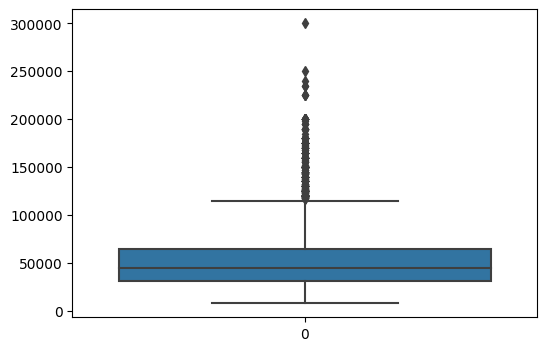

In [71]:
df_train_filtered = pd.DataFrame()
for cluster in range(NUMBER_OF_CLUSTERS):
    filterd = df_train_predicted[df_train_predicted['cluster']==cluster].copy().reset_index(drop=True)
    q_low = filterd["salary"].quantile(0.01)
    q_hi  = filterd["salary"].quantile(0.99)

    filterd = filterd[(filterd["salary"] < q_hi) & (filterd["salary"] > q_low)].copy()
    filterd.reset_index(drop=True, inplace=True)
    df_train_filtered = pd.concat([df_train_filtered, filterd], ignore_index=True)

sns.boxplot(df_train_filtered.salary)
df_train = df_train_filtered


In [74]:
import tqdm

VEC_LEN = 258
def vectorize(dataset):
    Xes = {}
    ys = {}
    for el, inp in enumerate(tqdm.tqdm(dataset, total=len(dataset))):
        src, trg = inp
        name_input_ids = src['name_input_ids']
        desc_input_ids = src['desc_input_ids']
        name_input_mask = src['name_input_mask']
        desc_input_mask = src['desc_input_mask']
        experience = src['experience'].numpy()
        schedule = src['schedule'].numpy()
        employment = src['employment'].numpy()
        key_skills = src['key_skills'].numpy()
        name_vec = name_input_ids
        desc_vec = desc_input_ids
        vec = np.concatenate((schedule, experience, employment, name_vec, desc_vec, key_skills))
        cluster_num = kmeans.predict(vec.reshape(1, -1))[0]  
        if cluster_num not in Xes:
            Xes[cluster_num] = []
            ys[cluster_num] = []
        Xes[cluster_num].append(vec)
        ys[cluster_num].append(trg.numpy())
        if el == len(dataset)-1:
            break
    return Xes, ys

# Xtrain, ytrain = vectorize(train_dataset)
# Xval, yval = vectorize(val_dataset)

Xtrain, ytrain = vectorize(full_dataset)
Xval, yval = Xtrain, ytrain

100%|█████████▉| 15697/15698 [01:00<00:00, 260.61it/s]


In [75]:
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.linear_model import SGDRegressor, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline

    
def create_voting_pipeline():
    reg1 = HistGradientBoostingRegressor(max_iter=150, max_leaf_nodes=150, learning_rate=0.03, verbose=1, l2_regularization=0.1, random_state = SEED)
    reg2 = RandomForestRegressor(n_jobs=-1, random_state = SEED, verbose=1)
    reg3 = LassoCV(max_iter=10_000, n_jobs=-1, random_state = SEED, verbose=1)
    reg4 = RidgeCV()
    reg5 = KNeighborsRegressor(n_jobs=-1)
    reg6 = LinearSVR(C=0.4, dual=False, epsilon=0.0072792775240143204, loss='squared_epsilon_insensitive', random_state=SEED, verbose=1)
    ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('svr', reg6)])

    return Pipeline([
        ('scaler', StandardScaler()), 
        ('ereg',  ereg)
        ])
    
pipes = {}
pipe_score = []
for cluster_num in range(0,NUMBER_OF_CLUSTERS):
    X = np.array(Xtrain[cluster_num])
    y = np.array(ytrain[cluster_num]).ravel()
    pipe = create_voting_pipeline()
    pipe.fit(X, y)
    score = pipe.score(X, y)
    pipes[cluster_num] = pipe
    pipe_score.append(score)
    
np.array(pipe_score).mean()

1 tree, 12 leaves, max depth = 5, in 0.084s
[117/150] 1 tree, 11 leaves, max depth = 6, in 0.106s
[118/150] 1 tree, 12 leaves, max depth = 8, in 0.077s
[119/150] 1 tree, 11 leaves, max depth = 5, in 0.093s
[120/150] 1 tree, 13 leaves, max depth = 9, in 0.074s
[121/150] 1 tree, 13 leaves, max depth = 7, in 0.082s
[122/150] 1 tree, 12 leaves, max depth = 5, in 0.082s
[123/150] 1 tree, 13 leaves, max depth = 6, in 0.073s
[124/150] 1 tree, 12 leaves, max depth = 7, in 0.064s
[125/150] 1 tree, 11 leaves, max depth = 7, in 0.110s
[126/150] 1 tree, 11 leaves, max depth = 6, in 0.079s
[127/150] 1 tree, 11 leaves, max depth = 5, in 0.076s
[128/150] 1 tree, 13 leaves, max depth = 6, in 0.079s
[129/150] 1 tree, 12 leaves, max depth = 7, in 0.217s
[130/150] 1 tree, 13 leaves, max depth = 6, in 0.087s
[131/150] 1 tree, 12 leaves, max depth = 6, in 0.065s
[132/150] 1 tree, 11 leaves, max depth = 5, in 0.074s
[133/150] 1 tree, 12 leaves, max depth = 7, in 0.072s
[134/150] 1 tree, 11 leaves, max depth

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s


[LibLinear]iter  1 act 5.119e+01 pre 5.096e+01 delta 6.791e-01 f 7.240e+01 |g| 4.230e+02 CG   9
cg reaches trust region boundary
iter  2 act 5.623e+00 pre 5.572e+00 delta 6.859e-01 f 2.121e+01 |g| 4.169e+01 CG  15
cg reaches trust region boundary
iter  3 act 1.088e+00 pre 1.160e+00 delta 6.859e-01 f 1.559e+01 |g| 9.500e+00 CG  29
iter  4 act -1.008e-02 pre 1.651e-01 delta 1.363e-01 f 1.450e+01 |g| 7.719e+00 CG  35
cg reaches trust region boundary
iter  4 act 3.253e-02 pre 1.292e-01 delta 7.798e-02 f 1.450e+01 |g| 7.719e+00 CG  21
cg reaches trust region boundary
iter  5 act 9.475e-02 pre 1.077e-01 delta 7.798e-02 f 1.447e+01 |g| 8.979e+00 CG  22
cg reaches trust region boundary
iter  6 act 2.354e-02 pre 2.426e-02 delta 7.798e-02 f 1.437e+01 |g| 3.628e+00 CG  23
iter  7 act 4.918e-04 pre 6.416e-03 delta 3.899e-02 f 1.435e+01 |g| 8.821e-01 CG  41
iter  8 act 5.848e-03 pre 5.848e-03 delta 3.899e-02 f 1.435e+01 |g| 2.662e+00 CG   6
iter  9 act 1.323e-04 pre 1.323e-04 delta 3.899e-02 f 1.43

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


0.158 s
Fitting gradient boosted rounds:
[1/150] 1 tree, 49 leaves, max depth = 11, in 0.529s
[2/150] 1 tree, 49 leaves, max depth = 10, in 0.103s
[3/150] 1 tree, 50 leaves, max depth = 11, in 0.081s
[4/150] 1 tree, 50 leaves, max depth = 10, in 0.074s
[5/150] 1 tree, 50 leaves, max depth = 11, in 0.079s
[6/150] 1 tree, 50 leaves, max depth = 10, in 0.090s
[7/150] 1 tree, 48 leaves, max depth = 14, in 0.089s
[8/150] 1 tree, 50 leaves, max depth = 11, in 0.097s
[9/150] 1 tree, 48 leaves, max depth = 13, in 0.071s
[10/150] 1 tree, 51 leaves, max depth = 12, in 0.072s
[11/150] 1 tree, 49 leaves, max depth = 13, in 0.092s
[12/150] 1 tree, 51 leaves, max depth = 13, in 0.079s
[13/150] 1 tree, 47 leaves, max depth = 13, in 0.092s
[14/150] 1 tree, 47 leaves, max depth = 13, in 0.087s
[15/150] 1 tree, 50 leaves, max depth = 10, in 0.098s
[16/150] 1 tree, 48 leaves, max depth = 11, in 0.095s
[17/150] 1 tree, 50 leaves, max depth = 12, in 0.094s
[18/150] 1 tree, 50 leaves, max depth = 12, in 0.0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished


[LibLinear]iter  1 act 1.469e+02 pre 1.463e+02 delta 6.403e-01 f 2.881e+02 |g| 8.247e+02 CG  10
iter  2 act 5.679e+00 pre 5.837e+00 delta 6.403e-01 f 1.413e+02 |g| 8.179e+01 CG  19
iter  3 act 1.297e-01 pre 1.607e-01 delta 6.403e-01 f 1.356e+02 |g| 1.704e+01 CG  18
iter  4 act 2.930e-02 pre 3.215e-02 delta 6.403e-01 f 1.354e+02 |g| 1.292e+01 CG   8
iter  5 act -2.364e-02 pre 5.671e-03 delta 3.509e-03 f 1.354e+02 |g| 2.835e+00 CG  24
cg reaches trust region boundary
iter  5 act 4.663e-05 pre 3.610e-03 delta 1.755e-03 f 1.354e+02 |g| 2.835e+00 CG   8
cg reaches trust region boundary
iter  6 act 2.961e-03 pre 3.441e-03 delta 1.755e-03 f 1.354e+02 |g| 4.015e+00 CG   3
cg reaches trust region boundary
iter  7 act 8.447e-04 pre 8.024e-04 delta 1.899e-03 f 1.354e+02 |g| 1.647e+00 CG   6
cg reaches trust region boundary
iter  8 act 5.067e-05 pre 4.210e-04 delta 9.495e-04 f 1.354e+02 |g| 6.486e-01 CG   6
cg reaches trust region boundary
iter  9 act 5.201e-04 pre 5.279e-04 delta 9.502e-04 f 1.35

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


0.165 s
Fitting gradient boosted rounds:
[1/150] 1 tree, 85 leaves, max depth = 15, in 0.118s
[2/150] 1 tree, 84 leaves, max depth = 14, in 0.106s
[3/150] 1 tree, 85 leaves, max depth = 15, in 0.109s
[4/150] 1 tree, 84 leaves, max depth = 15, in 0.109s
[5/150] 1 tree, 86 leaves, max depth = 14, in 0.096s
[6/150] 1 tree, 81 leaves, max depth = 15, in 0.089s
[7/150] 1 tree, 85 leaves, max depth = 12, in 0.110s
[8/150] 1 tree, 83 leaves, max depth = 14, in 0.103s
[9/150] 1 tree, 86 leaves, max depth = 14, in 0.114s
[10/150] 1 tree, 84 leaves, max depth = 12, in 0.107s
[11/150] 1 tree, 83 leaves, max depth = 19, in 0.103s
[12/150] 1 tree, 82 leaves, max depth = 14, in 0.108s
[13/150] 1 tree, 82 leaves, max depth = 14, in 0.102s
[14/150] 1 tree, 85 leaves, max depth = 14, in 0.100s
[15/150] 1 tree, 86 leaves, max depth = 17, in 0.113s
[16/150] 1 tree, 81 leaves, max depth = 14, in 0.106s
[17/150] 1 tree, 86 leaves, max depth = 13, in 0.092s
[18/150] 1 tree, 85 leaves, max depth = 13, in 0.0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished


[LibLinear]iter  1 act 2.469e+02 pre 2.456e+02 delta 4.613e-01 f 5.839e+02 |g| 2.280e+03 CG   7
cg reaches trust region boundary
iter  2 act 1.981e+01 pre 1.982e+01 delta 4.645e-01 f 3.370e+02 |g| 1.871e+02 CG  13
iter  3 act 1.659e+00 pre 1.657e+00 delta 4.645e-01 f 3.172e+02 |g| 4.168e+01 CG  23
iter  4 act 1.238e-02 pre 1.442e-02 delta 4.645e-01 f 3.155e+02 |g| 4.679e+00 CG  22
iter  5 act 2.076e-03 pre 2.083e-03 delta 4.645e-01 f 3.155e+02 |g| 2.722e+00 CG  12
iter  6 act -1.830e-01 pre 1.679e-04 delta 3.730e-03 f 3.155e+02 |g| 3.038e-01 CG  53
cg reaches trust region boundary
iter  6 act -8.762e-03 pre 8.749e-05 delta 9.325e-04 f 3.155e+02 |g| 3.038e-01 CG  36
cg reaches trust region boundary
iter  6 act 5.343e-05 pre 5.410e-05 delta 9.325e-04 f 3.155e+02 |g| 3.038e-01 CG  14
Binning 0.001 GB of training data: 

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


0.262 s
Fitting gradient boosted rounds:
[1/150] 1 tree, 27 leaves, max depth = 8, in 0.067s
[2/150] 1 tree, 30 leaves, max depth = 10, in 0.072s
[3/150] 1 tree, 29 leaves, max depth = 8, in 0.081s
[4/150] 1 tree, 29 leaves, max depth = 9, in 0.068s
[5/150] 1 tree, 26 leaves, max depth = 10, in 0.078s
[6/150] 1 tree, 28 leaves, max depth = 8, in 0.088s
[7/150] 1 tree, 30 leaves, max depth = 9, in 0.087s
[8/150] 1 tree, 27 leaves, max depth = 7, in 0.068s
[9/150] 1 tree, 27 leaves, max depth = 8, in 0.074s
[10/150] 1 tree, 27 leaves, max depth = 8, in 0.068s
[11/150] 1 tree, 27 leaves, max depth = 9, in 0.089s
[12/150] 1 tree, 28 leaves, max depth = 8, in 0.070s
[13/150] 1 tree, 27 leaves, max depth = 8, in 0.076s
[14/150] 1 tree, 27 leaves, max depth = 8, in 0.080s
[15/150] 1 tree, 28 leaves, max depth = 8, in 0.073s
[16/150] 1 tree, 27 leaves, max depth = 9, in 0.075s
[17/150] 1 tree, 26 leaves, max depth = 9, in 0.080s
[18/150] 1 tree, 27 leaves, max depth = 9, in 0.059s
[19/150] 1 t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


[LibLinear]iter  1 act 1.312e+02 pre 1.307e+02 delta 6.520e-01 f 2.297e+02 |g| 9.854e+02 CG   8
cg reaches trust region boundary
iter  2 act 1.343e+01 pre 1.343e+01 delta 6.573e-01 f 9.855e+01 |g| 9.313e+01 CG  12
cg reaches trust region boundary
iter  3 act 3.373e+00 pre 3.526e+00 delta 6.573e-01 f 8.512e+01 |g| 2.471e+01 CG  23
iter  4 act 4.842e-01 pre 4.851e-01 delta 6.573e-01 f 8.175e+01 |g| 1.171e+01 CG  36
iter  5 act -1.141e-01 pre 6.839e-03 delta 9.088e-03 f 8.126e+01 |g| 1.694e+00 CG  44
cg reaches trust region boundary
iter  5 act 3.869e-03 pre 4.036e-03 delta 9.088e-03 f 8.126e+01 |g| 1.694e+00 CG  11
cg reaches trust region boundary
iter  6 act 1.347e-03 pre 1.374e-03 delta 9.088e-03 f 8.126e+01 |g| 7.722e-01 CG  13
cg reaches trust region boundary
iter  7 act 6.571e-04 pre 6.584e-04 delta 9.122e-03 f 8.126e+01 |g| 5.381e-01 CG  17
cg reaches trust region boundary
iter  8 act -8.162e-03 pre 2.407e-04 delta 2.280e-03 f 8.126e+01 |g| 2.738e-01 CG  52
cg reaches trust region 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished


[LibLinear]iter  1 act 1.848e+02 pre 1.842e+02 delta 5.391e-01 f 3.485e+02 |g| 1.397e+03 CG   8
iter  2 act 8.924e+00 pre 8.948e+00 delta 5.391e-01 f 1.637e+02 |g| 1.185e+02 CG  16
iter  3 act 1.603e-01 pre 1.599e-01 delta 5.391e-01 f 1.548e+02 |g| 1.384e+01 CG  20
iter  4 act -4.482e+00 pre 6.263e-03 delta 2.292e-02 f 1.546e+02 |g| 1.526e+00 CG  48
cg reaches trust region boundary
iter  4 act -2.230e-01 pre 3.202e-03 delta 5.730e-03 f 1.546e+02 |g| 1.526e+00 CG  31
cg reaches trust region boundary
iter  4 act 1.013e-03 pre 1.992e-03 delta 3.853e-03 f 1.546e+02 |g| 1.526e+00 CG  13
iter  5 act 9.590e-04 pre 1.080e-03 delta 3.853e-03 f 1.546e+02 |g| 1.745e+00 CG  15
cg reaches trust region boundary
iter  6 act -5.784e-03 pre 2.005e-04 delta 9.632e-04 f 1.546e+02 |g| 5.499e-01 CG  20
cg reaches trust region boundary
iter  6 act -7.377e-06 pre 1.436e-04 delta 4.695e-04 f 1.546e+02 |g| 5.499e-01 CG  13
cg reaches trust region boundary
iter  6 act 1.199e-04 pre 1.209e-04 delta 4.695e-04 f 1

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


0.158 s
Fitting gradient boosted rounds:
[1/150] 1 tree, 6 leaves, max depth = 4, in 0.088s
[2/150] 1 tree, 5 leaves, max depth = 3, in 0.082s
[3/150] 1 tree, 6 leaves, max depth = 4, in 0.100s
[4/150] 1 tree, 5 leaves, max depth = 3, in 0.090s
[5/150] 1 tree, 6 leaves, max depth = 3, in 0.088s
[6/150] 1 tree, 6 leaves, max depth = 4, in 0.069s
[7/150] 1 tree, 6 leaves, max depth = 5, in 0.093s
[8/150] 1 tree, 7 leaves, max depth = 4, in 0.107s
[9/150] 1 tree, 6 leaves, max depth = 3, in 0.083s
[10/150] 1 tree, 6 leaves, max depth = 4, in 0.078s
[11/150] 1 tree, 7 leaves, max depth = 4, in 0.079s
[12/150] 1 tree, 6 leaves, max depth = 4, in 0.069s
[13/150] 1 tree, 6 leaves, max depth = 4, in 0.078s
[14/150] 1 tree, 6 leaves, max depth = 4, in 0.088s
[15/150] 1 tree, 6 leaves, max depth = 3, in 0.076s
[16/150] 1 tree, 7 leaves, max depth = 4, in 0.078s
[17/150] 1 tree, 6 leaves, max depth = 5, in 0.077s
[18/150] 1 tree, 6 leaves, max depth = 3, in 0.069s
[19/150] 1 tree, 6 leaves, max d

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s


[LibLinear]iter  1 act 1.225e+02 pre 1.223e+02 delta 1.492e+00 f 1.335e+02 |g| 3.532e+02 CG  10
iter  2 act 4.042e+00 pre 7.516e+00 delta 9.525e-01 f 1.105e+01 |g| 3.310e+01 CG  27
iter  3 act 3.246e+00 pre 3.318e+00 delta 9.525e-01 f 7.011e+00 |g| 4.315e+01 CG  12
iter  4 act -4.420e+00 pre 3.008e-01 delta 1.135e-01 f 3.765e+00 |g| 6.686e+00 CG  36
cg reaches trust region boundary
iter  4 act 1.145e-01 pre 1.718e-01 delta 8.613e-02 f 3.765e+00 |g| 6.686e+00 CG  11
cg reaches trust region boundary
iter  5 act 3.851e-02 pre 9.421e-02 delta 5.434e-02 f 3.651e+00 |g| 5.462e+00 CG  13
cg reaches trust region boundary
iter  6 act 2.882e-02 pre 6.570e-02 delta 3.488e-02 f 3.612e+00 |g| 5.388e+00 CG  12
cg reaches trust region boundary
iter  7 act 2.702e-02 pre 3.742e-02 delta 2.731e-02 f 3.583e+00 |g| 4.452e+00 CG  12
cg reaches trust region boundary
iter  8 act 1.041e-02 pre 1.224e-02 delta 2.731e-02 f 3.556e+00 |g| 2.561e+00 CG  13
cg reaches trust region boundary
iter  9 act 4.089e-03 pre

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


0.194 s
Fitting gradient boosted rounds:
[1/150] 1 tree, 34 leaves, max depth = 9, in 0.088s
[2/150] 1 tree, 33 leaves, max depth = 9, in 0.082s
[3/150] 1 tree, 32 leaves, max depth = 10, in 0.167s
[4/150] 1 tree, 34 leaves, max depth = 9, in 0.077s
[5/150] 1 tree, 34 leaves, max depth = 9, in 0.097s
[6/150] 1 tree, 36 leaves, max depth = 13, in 0.079s
[7/150] 1 tree, 34 leaves, max depth = 9, in 0.084s
[8/150] 1 tree, 34 leaves, max depth = 13, in 0.075s
[9/150] 1 tree, 35 leaves, max depth = 9, in 0.072s
[10/150] 1 tree, 33 leaves, max depth = 9, in 0.112s
[11/150] 1 tree, 38 leaves, max depth = 13, in 0.081s
[12/150] 1 tree, 33 leaves, max depth = 8, in 0.074s
[13/150] 1 tree, 33 leaves, max depth = 9, in 0.080s
[14/150] 1 tree, 34 leaves, max depth = 9, in 0.086s
[15/150] 1 tree, 33 leaves, max depth = 12, in 0.066s
[16/150] 1 tree, 34 leaves, max depth = 11, in 0.074s
[17/150] 1 tree, 34 leaves, max depth = 11, in 0.109s
[18/150] 1 tree, 35 leaves, max depth = 11, in 0.080s
[19/15

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


[LibLinear]iter  1 act 1.521e+02 pre 1.514e+02 delta 6.178e-01 f 2.016e+02 |g| 8.259e+02 CG   7
cg reaches trust region boundary
iter  2 act 1.022e+01 pre 1.023e+01 delta 6.239e-01 f 4.957e+01 |g| 6.084e+01 CG  15
cg reaches trust region boundary
iter  3 act 2.267e+00 pre 2.267e+00 delta 6.275e-01 f 3.934e+01 |g| 1.857e+01 CG  24
cg reaches trust region boundary
iter  4 act 6.841e-01 pre 7.360e-01 delta 6.275e-01 f 3.707e+01 |g| 7.090e+00 CG  37
iter  5 act 1.312e-01 pre 1.310e-01 delta 6.275e-01 f 3.639e+01 |g| 5.830e+00 CG  65
iter  6 act 3.620e-03 pre 3.625e-03 delta 6.275e-01 f 3.626e+01 |g| 7.475e-01 CG  75
Binning 0.004 GB of training data: 

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


0.228 s
Fitting gradient boosted rounds:
[1/150] 1 tree, 69 leaves, max depth = 12, in 0.149s
[2/150] 1 tree, 69 leaves, max depth = 12, in 0.126s
[3/150] 1 tree, 70 leaves, max depth = 12, in 0.133s
[4/150] 1 tree, 71 leaves, max depth = 12, in 0.123s
[5/150] 1 tree, 70 leaves, max depth = 12, in 0.131s
[6/150] 1 tree, 70 leaves, max depth = 12, in 0.126s
[7/150] 1 tree, 69 leaves, max depth = 13, in 0.131s
[8/150] 1 tree, 70 leaves, max depth = 13, in 0.134s
[9/150] 1 tree, 70 leaves, max depth = 11, in 0.128s
[10/150] 1 tree, 68 leaves, max depth = 15, in 0.124s
[11/150] 1 tree, 68 leaves, max depth = 14, in 0.181s
[12/150] 1 tree, 71 leaves, max depth = 14, in 0.114s
[13/150] 1 tree, 71 leaves, max depth = 14, in 0.128s
[14/150] 1 tree, 69 leaves, max depth = 15, in 0.113s
[15/150] 1 tree, 65 leaves, max depth = 13, in 0.118s
[16/150] 1 tree, 66 leaves, max depth = 14, in 0.120s
[17/150] 1 tree, 68 leaves, max depth = 12, in 0.140s
[18/150] 1 tree, 71 leaves, max depth = 14, in 0.1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished


[LibLinear]iter  1 act 2.077e+02 pre 2.070e+02 delta 5.156e-01 f 3.136e+02 |g| 1.358e+03 CG   6
iter  2 act 1.030e+01 pre 1.043e+01 delta 5.156e-01 f 1.059e+02 |g| 1.133e+02 CG  21
iter  3 act 2.325e-01 pre 2.354e-01 delta 5.156e-01 f 9.561e+01 |g| 1.616e+01 CG  25
iter  4 act 3.277e-03 pre 3.273e-03 delta 5.156e-01 f 9.538e+01 |g| 2.089e+00 CG  25
iter  5 act -1.717e-05 pre 4.427e-05 delta 5.259e-04 f 9.538e+01 |g| 1.812e-01 CG  28
cg reaches trust region boundary
iter  5 act 2.821e-05 pre 2.837e-05 delta 5.261e-04 f 9.538e+01 |g| 1.812e-01 CG  10
Binning 0.001 GB of training data: 

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


0.171 s
Fitting gradient boosted rounds:
[1/150] 1 tree, 15 leaves, max depth = 7, in 0.061s
[2/150] 1 tree, 15 leaves, max depth = 7, in 0.105s
[3/150] 1 tree, 14 leaves, max depth = 7, in 0.073s
[4/150] 1 tree, 15 leaves, max depth = 7, in 0.067s
[5/150] 1 tree, 14 leaves, max depth = 7, in 0.067s
[6/150] 1 tree, 15 leaves, max depth = 7, in 0.078s
[7/150] 1 tree, 13 leaves, max depth = 7, in 0.094s
[8/150] 1 tree, 15 leaves, max depth = 7, in 0.095s
[9/150] 1 tree, 14 leaves, max depth = 7, in 0.070s
[10/150] 1 tree, 15 leaves, max depth = 7, in 0.080s
[11/150] 1 tree, 14 leaves, max depth = 8, in 0.078s
[12/150] 1 tree, 14 leaves, max depth = 6, in 0.075s
[13/150] 1 tree, 14 leaves, max depth = 6, in 0.064s
[14/150] 1 tree, 14 leaves, max depth = 8, in 0.068s
[15/150] 1 tree, 14 leaves, max depth = 6, in 0.070s
[16/150] 1 tree, 14 leaves, max depth = 7, in 0.075s
[17/150] 1 tree, 16 leaves, max depth = 6, in 0.076s
[18/150] 1 tree, 14 leaves, max depth = 8, in 0.077s
[19/150] 1 tre

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s


[LibLinear]iter  1 act 5.040e+01 pre 5.014e+01 delta 4.918e-01 f 8.266e+01 |g| 4.811e+02 CG   7
cg reaches trust region boundary
iter  2 act 6.054e+00 pre 6.049e+00 delta 5.015e-01 f 3.226e+01 |g| 4.707e+01 CG  11
cg reaches trust region boundary
iter  3 act 1.753e+00 pre 2.025e+00 delta 5.015e-01 f 2.621e+01 |g| 1.590e+01 CG  13
cg reaches trust region boundary
iter  4 act 1.058e+00 pre 1.076e+00 delta 5.015e-01 f 2.445e+01 |g| 1.830e+01 CG  19
cg reaches trust region boundary
iter  5 act 3.767e-01 pre 3.741e-01 delta 5.076e-01 f 2.340e+01 |g| 6.734e+00 CG  30
iter  6 act -1.283e-02 pre 4.390e-02 delta 7.680e-02 f 2.302e+01 |g| 1.924e+00 CG  49
cg reaches trust region boundary
iter  6 act 2.769e-02 pre 3.045e-02 delta 7.680e-02 f 2.302e+01 |g| 1.924e+00 CG  19
cg reaches trust region boundary
iter  7 act 1.049e-02 pre 1.058e-02 delta 7.680e-02 f 2.299e+01 |g| 2.381e+00 CG  24
iter  8 act 3.435e-03 pre 3.435e-03 delta 7.680e-02 f 2.298e+01 |g| 6.661e-01 CG  43
iter  9 act 5.559e-05 pre

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


0.210 s
Fitting gradient boosted rounds:
[1/150] 1 tree, 80 leaves, max depth = 12, in 0.113s
[2/150] 1 tree, 79 leaves, max depth = 13, in 0.199s
[3/150] 1 tree, 78 leaves, max depth = 13, in 0.101s
[4/150] 1 tree, 80 leaves, max depth = 12, in 0.090s
[5/150] 1 tree, 77 leaves, max depth = 13, in 0.101s
[6/150] 1 tree, 80 leaves, max depth = 13, in 0.105s
[7/150] 1 tree, 80 leaves, max depth = 13, in 0.124s
[8/150] 1 tree, 79 leaves, max depth = 12, in 0.097s
[9/150] 1 tree, 79 leaves, max depth = 15, in 0.113s
[10/150] 1 tree, 81 leaves, max depth = 12, in 0.108s
[11/150] 1 tree, 77 leaves, max depth = 13, in 0.104s
[12/150] 1 tree, 77 leaves, max depth = 12, in 0.097s
[13/150] 1 tree, 78 leaves, max depth = 15, in 0.105s
[14/150] 1 tree, 80 leaves, max depth = 13, in 0.101s
[15/150] 1 tree, 76 leaves, max depth = 13, in 0.094s
[16/150] 1 tree, 73 leaves, max depth = 13, in 0.100s
[17/150] 1 tree, 75 leaves, max depth = 13, in 0.099s
[18/150] 1 tree, 79 leaves, max depth = 14, in 0.0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.5s finished


[LibLinear]iter  1 act 2.913e+02 pre 2.906e+02 delta 4.866e-01 f 6.612e+02 |g| 2.365e+03 CG   7
iter  2 act 2.172e+01 pre 2.169e+01 delta 4.866e-01 f 3.699e+02 |g| 2.383e+02 CG  17
iter  3 act 3.730e-01 pre 3.770e-01 delta 4.866e-01 f 3.482e+02 |g| 2.135e+01 CG  22
iter  4 act 6.350e-03 pre 6.349e-03 delta 4.866e-01 f 3.478e+02 |g| 2.544e+00 CG  26


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


0.865813628534443

In [76]:
pipe_score

[0.8755498672293497,
 0.898536040644525,
 0.8966642592983133,
 0.8855582440006682,
 0.856714123808715,
 0.8122986548226785,
 0.8582300639046561,
 0.8904746180336466,
 0.926112862145143,
 0.7980357370207247,
 0.9137612993054314,
 0.8177615670326381,
 0.8363673331936217,
 0.8675933105515105,
 0.8575685017747292,
 0.9307243071270065,
 0.8597379519841877,
 0.8186596781925123,
 0.890130053325865,
 0.8257940972929356]

In [ ]:
resuduals_df = df_train.copy()
predicted = salary_scaler.inverse_transform(pipe.predict(Xval)[:, np.newaxis])
resuduals_df['predicted'] = predicted
resuduals_df['resudual'] = resuduals_df.salary - resuduals_df.predicted
resuduals_df[['experience', 'schedule', 'name_cleaned','salary', 'resudual', 'predicted', 'description_cleaned', 'key_skills', 'employment']].to_csv('data/val_predicted.csv', index=False)

In [77]:
predictions = []
for el, inp in enumerate(tqdm.tqdm(test_dataset, total=len(test_dataset))):
    src, trg = inp
    name_input_ids = src['name_input_ids']
    desc_input_ids = src['desc_input_ids']
    name_input_mask = src['name_input_mask']
    desc_input_mask = src['desc_input_mask']
    experience = src['experience'].numpy()
    schedule = src['schedule'].numpy()
    employment = src['employment'].numpy()
    key_skills = src['key_skills'].numpy()
    name_vec = name_input_ids
    desc_vec = desc_input_ids
    X = np.concatenate((schedule, experience, employment, name_vec, desc_vec, key_skills)).reshape(1, -1)
    cluster_num = kmeans.predict(X)[0]  
    normalized_pred = pipes[cluster_num].predict(X)
    prediction = salary_scaler.inverse_transform(normalized_pred.reshape(1, -1))
    predictions.append(prediction)
    if el == len(test_dataset)-1:
        break

test_pred = np.array(predictions)

  0%|          | 0/5543 [00:00<?, ?it/s][Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
  0%|          | 1/5543 [00:00<39:11,  2.36it/s][Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
  0%|          | 3/5543 [00:00<14:20,  6.44it/s][Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Par

In [95]:
test_pred = test_pred.reshape(5543,)


In [97]:
predictions = pd.DataFrame({'id': df_test.index,
                            'salary': test_pred})

def substitute_from_train(row):
    id = int(row.id)
    salary = row.salary
    if id in full_match_mean_salary:
        row.salary = full_match_mean_salary[id]
    elif id in partial_match_mean_salary:
        row.salary = (partial_match_mean_salary[id] + salary)/2
    row.id = id
    return row

predictions = predictions.apply(substitute_from_train, axis=1)
predictions = predictions.astype({'id': 'int32'})
predictions.to_csv('my_submission.csv', index=False)

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:x.size(1)]
        return self.dropout(x)
    
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, embedding_dim: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.name_model_len = embedding_dim * MAX_NAME_SEQ_LEN
        self.desc_model_len = embedding_dim * MAX_DESC_SEQ_LEN
        model_len = embedding_dim * 2 + EXPERIENCE_BITS_LEN + SCHEDULE_BITS_LEN + EMPLOYMENT_BITS_LEN 
        self.embedding_dim = embedding_dim
        self.encoder = nn.Embedding(ntoken, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim, dropout)
        name_encoder_layers = nn.TransformerEncoderLayer(embedding_dim, nhead, d_hid, dropout, batch_first=True)
        desc_encoder_layers = nn.TransformerEncoderLayer(embedding_dim, nhead, d_hid, dropout, batch_first=True)
        self.name_transformer_encoder = nn.TransformerEncoder(name_encoder_layers, nlayers)
        self.desc_transformer_encoder = nn.TransformerEncoder(desc_encoder_layers, nlayers)
        self.relu = nn.ReLU()
        self.batch_horm = nn.BatchNorm1d(model_len)
        self.name_decoder0 = nn.Linear(self.name_model_len, embedding_dim, bias=True)
        self.desc_decoder0 = nn.Linear(self.desc_model_len, embedding_dim, bias=True)
        self.decoder0 = nn.Linear(model_len, model_len, bias=True)
        self.decoder1 = nn.Linear(model_len, 1, bias=True)
        
    def forward(self, src: Tensor) -> Tensor:
        name_input_ids = src['name_input_ids']
        desc_input_ids = src['desc_input_ids']
        name_input_mask = src['name_input_mask']
        desc_input_mask = src['desc_input_mask']
        experience = src['experience']
        schedule = src['schedule']
        employment = src['employment']
        key_skills = src['key_skills']
        # input_ids = self.encoder(input_ids) * math.sqrt(self.embedding_dim)
        # input_ids = input_ids * math.sqrt(self.embedding_dim)
        name_input_ids = self.pos_encoder(name_input_ids)
        name_input_ids = self.name_transformer_encoder(name_input_ids, src_key_padding_mask=name_input_mask)
        name_input_ids = name_input_ids.masked_fill(torch.isnan(name_input_ids), 0)
        name_input_ids = torch.flatten(name_input_ids, 1)
        name_input_ids = self.relu(self.name_decoder0(name_input_ids))
        
        desc_input_ids = self.pos_encoder(desc_input_ids)
        desc_input_ids = self.desc_transformer_encoder(desc_input_ids, src_key_padding_mask=desc_input_mask)
        desc_input_ids = desc_input_ids.masked_fill(torch.isnan(desc_input_ids), 0)
        desc_input_ids = torch.flatten(desc_input_ids, 1)
        desc_input_ids = self.relu(self.desc_decoder0(desc_input_ids))
        
        # input_ids = self.pos_encoder(input_ids)
        # input_ids = self.transformer_encoder(input_ids, src_key_padding_mask=src_key_input_mask)
        # input_ids = input_ids.masked_fill(torch.isnan(input_ids), 0)
        # input_ids = input_ids.mean(1)
        output = torch.cat((experience, schedule, employment, name_input_ids, desc_input_ids), 1)
        output = self.batch_horm(output)
        output = self.relu(self.decoder0(output))
        output = self.decoder1(output)
        return output
    
ntokens = len(w2v_model.wv.key_to_index)  # size of vocabulary
emsize = 120  # embedding dimension
emsize = FASTTEXT_EMB_LEN  # embedding dimension
d_hid = 768  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 8  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 10  # number of heads in nn.MultiheadAttention
dropout = 0.1  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

In [ ]:
BATCH_SIZE = 8

def scheduler(optim): return \
    torch.optim.lr_scheduler.ReduceLROnPlateau(
        optim, patience=5, factor=0.5, verbose=True)
    
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

best_val_loss, best_model = train_eval_loop(model=model,
                                            device=device,
                                            train_dataset=train_dataset,
                                            val_dataset=val_dataset,
                                            criterion=F.mse_loss,
                                            lr=1e-4,
                                            epoch_n=10,
                                            batch_size=BATCH_SIZE,
                                            l2_reg_alpha=0.1,
                                            lr_scheduler_ctor=scheduler,
                                            shuffle_train=False
                                            )

In [ ]:
val_pred, y_val = predict_with_model(best_model, val_dataset, batch_size=BATCH_SIZE, device=device, return_labels=True)
val_pred = salary_scaler.inverse_transform(val_pred)
y_val = salary_scaler.inverse_transform(y_val)
val_loss = F.mse_loss(torch.from_numpy(val_pred),
                            torch.from_numpy(y_val))

print('Mean value train loss function', float(val_loss))
print('R2 score', r2_score(y_val, val_pred))

In [ ]:
test_pred = predict_with_model(model, test_dataset, batch_size=BATCH_SIZE, device=device, return_labels=False)
test_pred = salary_scaler.inverse_transform(test_pred)
test_pred

In [ ]:
predictions = pd.DataFrame({'id': df_test.index,
                            'salary': test_pred})
predictions.to_csv('my_submission.csv', index=False)